In [1]:
import numpy as np
import script
import pylab as plt
import nibabel as nib
import os
from skimage import filters
import scipy.ndimage as ndi
from scipy.ndimage.morphology import binary_erosion as be
from scipy.ndimage.morphology import binary_fill_holes as bfh
from scipy.ndimage.morphology import binary_dilation as bd
from scipy.ndimage.morphology import binary_opening as bo
from scipy.ndimage.morphology import binary_closing as bc
from scipy.ndimage.morphology import grey_dilation as gd
import BET
import time
from skimage.segmentation import find_boundaries as boundaries
import skimage

In [2]:
planes = np.load('pre_op_planes.npy')

samps = ['Sample-1', 'Sample-2', 'Sample-3', 'Sample-4', 'Sample-5', 'Sample-A',
 'Sample-B', 'Sample-C', 'Sample-D', 'Sample-F', 'Sample-G', 'Sample-H',
 'Sample-I']

reshaped_niftis = []
for i in range(len(samps)):
    reshaped_niftis.append(os.path.join('/Volumes/SINEADUSB/DC-project-Images/processed/pre-samples/', 
                                        '{}.nii.gz'.format(samps[i])))

In [3]:
i = 2
path = reshaped_niftis[i]
samp = samps[i]

In [4]:
print samp

Sample-3


In [5]:
img = nib.load(path)

In [6]:
array0 = img.get_data()

# 1. Remove Skin

In [7]:
def remove_skin(array):
    filtered = skimage.filters.gaussian(array, sigma=1)
    thresholded1 = np.multiply(filtered, (filtered>-200).astype(int))
    thresholded2 = np.multiply(thresholded1, (abs(thresholded1)>0.1).astype(int))
    return thresholded2

skin_mask = array0

for i in range(7):
    skin_mask = remove_skin(skin_mask)
    
skin_mask = np.multiply(skin_mask, (skin_mask>-200).astype(int))

In [8]:
array1 = np.multiply(array0, (skin_mask>0.0).astype(int))
array1 = np.multiply(array1, (array1>-200).astype(int))

# 2. Remove Skull

In [9]:
skull_mask = array1>84.0
array2 = np.multiply(array1, (array1<84.0).astype(int))

# 3. Remove Orbital Region

In [10]:
orbital_mask = skull_mask

In [11]:
for i in range(5):
    orbital_mask = bd(skull_mask)

In [12]:
array3 = np.multiply(array2, (orbital_mask==False).astype(int))

# 4. Eliminate Cerebral Ventricle 

In [13]:
array4 = np.multiply(array3, (array3>0.0).astype(int))

# 5. Cannot Create Dmap

In [14]:
array5 = BET.extract(array4, samp)

In [15]:
brain_mask = np.multiply(bc(bfh(bd(array5))).astype(int), array5)

<IPython.core.display.Javascript object>


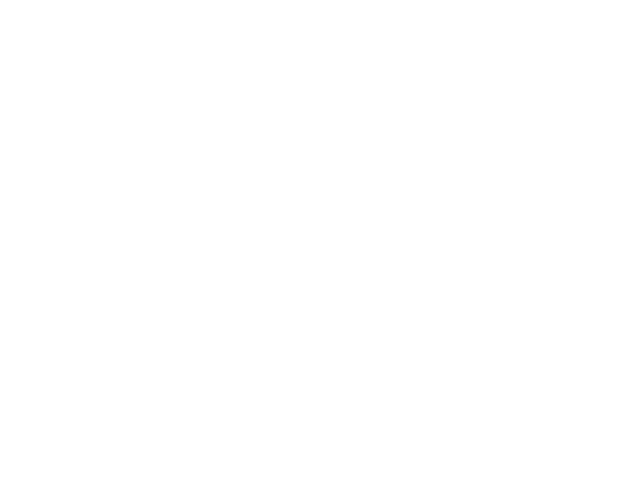

In [16]:
%matplotlib nbagg

plt.imshow(brain_mask[:,:,100], cmap='gray')
plt.show()
plt.ion()

# 6. Get Ventricles

In [17]:
ventr_mask1 = np.multiply((brain_mask>0).astype(int), (brain_mask<20).astype(int))

In [18]:
ventr_mask2 = bd(ventr_mask1)

In [19]:
ventr_mask3 = be(ventr_mask2)

In [20]:
ventr_mask4 = bfh(ventr_mask3)

In [21]:
import skimage
labels = skimage.measure.label(ventr_mask4, connectivity=3)
props = skimage.measure.regionprops(labels)
v = [p.area for p in props]
ind = v.index(max(v))
vcoords = props[ind].coords
ventr_mask3 = np.zeros((ventr_mask2.shape))
for i in range(len(vcoords)):
    a,b,c = vcoords[i]
    ventr_mask3[a,b,c]=1

<IPython.core.display.Javascript object>


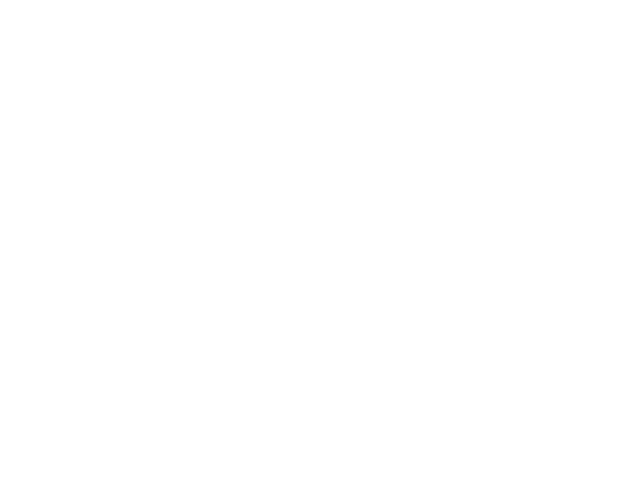

In [22]:
%matplotlib nbagg

plt.imshow(ventr_mask4[:,:,100], cmap='gray')
plt.show()
plt.ion()

In [23]:
img = nib.Nifti1Image((ventr_mask4).astype(float)*1000, np.eye(4))
nib.save(img, '/Users/Sinead/DC-project/v-mask-{}.nii.gz'.format(samp))

In [24]:
img = nib.Nifti1Image(array5, np.eye(4))
nib.save(img, '/Users/Sinead/DC-project/pre-adapted-kondo-paper-{}.nii.gz'.format(samp))

In [25]:
h_mask = (array5>50.0).astype(float)*1000

# img = nib.Nifti1Image(h_mask, np.eye(4))
# nib.save(img, '/Users/Sinead/DC-project/h-mask-50-{}.nii.gz'.format(samp))
array6 = np.multiply(brain_mask, h_mask)
array7 = be(array6)
array8 = bc((array7))
array9 = bfh((array8))
array10 = bd(bd((array8)))
array11 = bfh(bd(array10))

# pick out connected region for haemotoma

In [26]:
import skimage
labels = skimage.measure.label(array10, connectivity=1)

props = skimage.measure.regionprops(labels)
h = props[0].coords
mask = np.zeros((array10.shape))
for i in range(len(h)):
    a,b,c = h[i]
    mask[a,b,c]=1

In [27]:
img = nib.Nifti1Image((mask).astype(float)*1000, np.eye(4))
nib.save(img, '/Users/Sinead/DC-project/h-mask-{}.nii.gz'.format(samp))

<IPython.core.display.Javascript object>


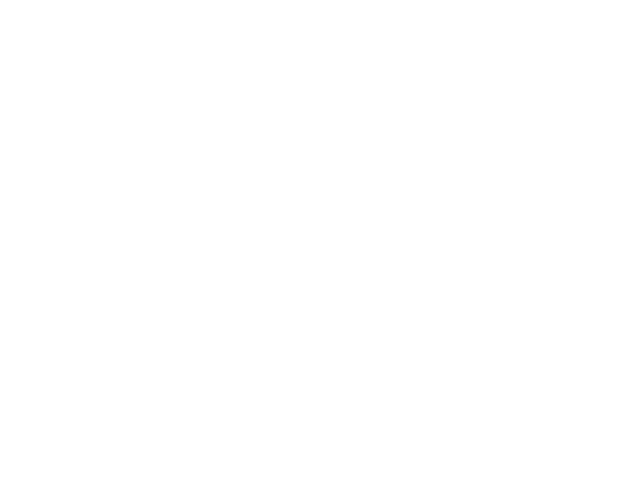

In [28]:
%matplotlib nbagg

plt.imshow((mask)[:,:,80], cmap='gray')
plt.show()
plt.ion()

##  Find volumes

In [36]:
samps = ['Sample-1', 'Sample-2', 'Sample-3', 'Sample-4', 'Sample-5', 'Sample-A',
 'Sample-B', 'Sample-C', 'Sample-D', 'Sample-F', 'Sample-G', 'Sample-H',
 'Sample-I']

planes = np.load('pre_op_planes.npy')
a,b,c,d = planes[2]

reshaped_niftis = []
for i in range(len(samps)):
    reshaped_niftis.append(os.path.join('/Volumes/SINEADUSB/DC-project-Images/processed/pre-samples/', 
                                        '{}.nii.gz'.format(samps[i])))
    
img = nib.load(reshaped_niftis[2])
shape = img.get_data().shape

midplane_split = np.zeros(shape)

for k in range(shape[2]):
    x = np.arange(0,shape[0],1)
    z = np.linspace(0,shape[2],shape[0])
    xx, yy = np.meshgrid(z, (d-c*z-a*x)/b)
    y = yy.astype(int)
    for j in range(len(y)):
        midplane_split[y[k,j]:shape[0],:, k]=1

In [37]:
v_mask = (ventr_mask4).astype(int)

In [38]:
%matplotlib nbagg
left_h = np.multiply(mask, midplane_split==0)
right_h = np.multiply(mask, midplane_split==1)

left_v = np.multiply(v_mask, midplane_split==0)
right_v = np.multiply(v_mask, midplane_split==1)

brain = np.multiply(brain_mask, (mask==0).astype(int)) # no haematoma

left_brain = np.multiply(brain, midplane_split==0)
right_brain = np.multiply(brain, midplane_split==1)

In [64]:
brainArea = []
for i in range(brain.shape[2]):
    brainArea.append(np.count_nonzero(brain[:,:,i]))
midsliceIndex = np.argmax(brainArea)



In [96]:
for i in range(len(brainArea)):
    if(brainArea[i]==0):
        pass
    else:
        break
start = i

for i in range(len(brainArea)-1, 0, -1):
    if(brainArea[i]==0):
        pass
    else:
        break
end = i

151

In [104]:
start = np.nonzero(brain[:,:,start])
b1, a1= np.mean(start[0]), np.mean(start[1])

end = np.nonzero(brain[:,:,end])
b2, a2= np.mean(end[0]), np.mean(end[1])

In [130]:
vCentroids = []
for i in range(v_mask.shape[2]):
    vCentroids.append(np.nonzero(v_mask[:,:,i]))

In [137]:
xV,yV = np.array(vCentroids).T
xV

array([array([], dtype=int64), array([], dtype=int64),
       array([], dtype=int64), array([], dtype=int64),
       array([], dtype=int64), array([], dtype=int64),
       array([], dtype=int64), array([], dtype=int64),
       array([], dtype=int64), array([], dtype=int64),
       array([], dtype=int64), array([], dtype=int64),
       array([], dtype=int64), array([], dtype=int64),
       array([], dtype=int64), array([], dtype=int64),
       array([], dtype=int64), array([94, 96, 97]), array([96, 96, 96]),
       array([89, 95]), array([98, 98]), array([ 98,  99,  99, 100]),
       array([ 92,  93,  99, 100]), array([92, 93]), array([92, 93, 94]),
       array([139, 140, 140]), array([139]), array([82]),
       array([], dtype=int64), array([], dtype=int64), array([73]),
       array([], dtype=int64), array([74]), array([], dtype=int64),
       array([ 76,  77,  77, 129, 146]), array([ 77,  78,  78, 146]),
       array([ 77,  78,  78, 126, 127, 142, 142, 146, 147, 149]),
       array(

73.0 90.0


<IPython.core.display.Javascript object>


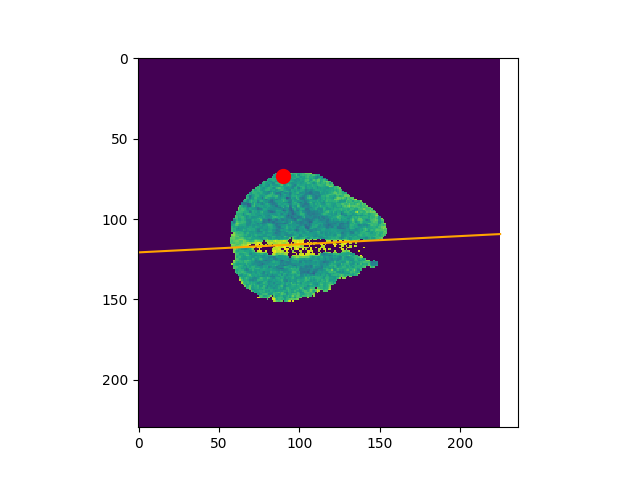

In [146]:
i = 30

%matplotlib nbagg


x = np.linspace(0,brain[:,:,i].shape[1], 2)
y = (d-c*i-a*x)/b

nonzeros = np.nonzero(v_mask[:,:,i])
w2, w1 = np.mean(nonzeros[0]), np.mean(nonzeros[1])
print w2, w1
plt.clf()
plt.imshow(brain[:,:,i])
plt.plot(x,y, color='orange')
plt.scatter(w1, w2, s=100, c='r')
plt.show()
plt.ion()



<IPython.core.display.Javascript object>


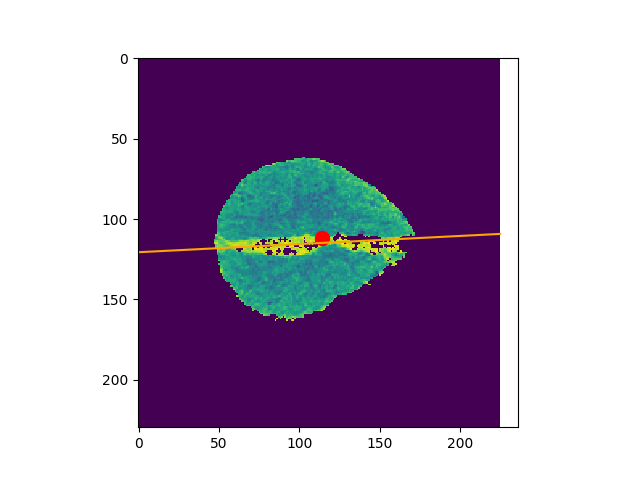

In [147]:
i =40 

%matplotlib nbagg



x = np.linspace(0,brain[:,:,i].shape[1], 2)
y = (d-c*i-a*x)/b

nonzeros = np.nonzero(v_mask[:,:,i])
w2, w1 = np.mean(nonzeros[0]), np.mean(nonzeros[1])

plt.clf()
plt.imshow(brain[:,:,i])
plt.plot(x,y, color='orange')
plt.scatter(w1, w2, s=100, c='r')
plt.show()
plt.ion()

<IPython.core.display.Javascript object>


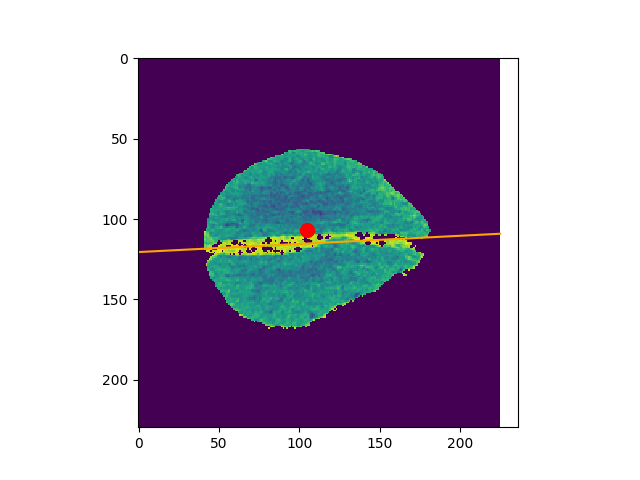

In [148]:
i =50

%matplotlib nbagg



x = np.linspace(0,brain[:,:,i].shape[1], 2)
y = (d-c*i-a*x)/b

nonzeros = np.nonzero(v_mask[:,:,i])
w2, w1 = np.mean(nonzeros[0]), np.mean(nonzeros[1])

plt.clf()
plt.imshow(brain[:,:,i])
plt.plot(x,y, color='orange')
plt.scatter(w1, w2, s=100, c='r')
plt.show()
plt.ion()

<IPython.core.display.Javascript object>


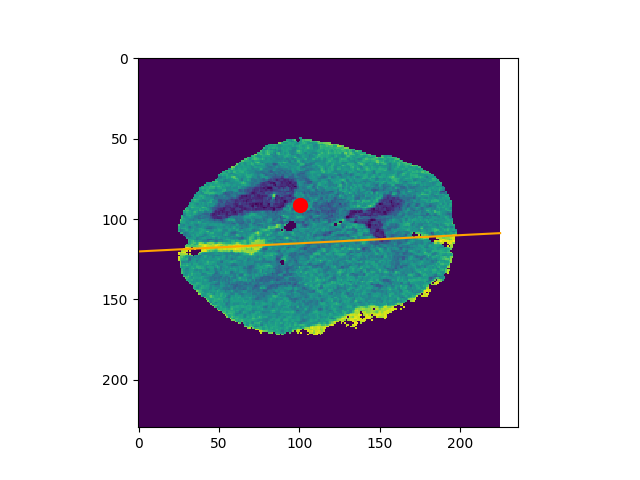

In [153]:
i =60

%matplotlib nbagg



x = np.linspace(0,brain[:,:,i].shape[1], 2)
y = (d-c*i-a*x)/b

nonzeros = np.nonzero(v_mask[:,:,i])
w2, w1 = np.mean(nonzeros[0]), np.mean(nonzeros[1])

plt.clf()
plt.imshow(brain[:,:,i])
plt.plot(x,y, color='orange')
plt.scatter(w1, w2, s=100, c='r')
plt.show()
plt.ion()


<IPython.core.display.Javascript object>


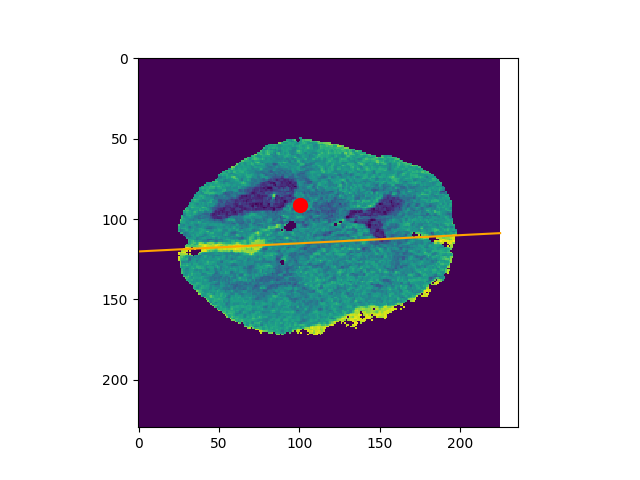

In [155]:
i = 88
%matplotlib nbagg

x = np.linspace(0,brain[:,:,i].shape[1], 2)
y = (d-c*i-a*x)/b

nonzeros = np.nonzero(v_mask[:,:,i])
w2, w1 = np.mean(nonzeros[0]), np.mean(nonzeros[1])

plt.clf()
plt.imshow(brain[:,:,i])
plt.plot(x,y, color='orange')
plt.scatter(w1, w2, s=100, c='r')
plt.show()
plt.ion()

In [164]:
w2, w1

(91.536472760849492, 100.57340720221606)

In [128]:
slice_ = brain[:,:,88]
xx = np.arange(0, x[-1], 1).astype(int)
yy = np.arange(0,y[-1],1).astype(int)
for i in range(brain[:,:,88].shape[1]):
    if(slice_[xx[i],yy[i]])==0:
        pass
    else:
        break
xstart = xx[i]
ystart = yy[i]

slice_ = brain[:,:,88]
xx = np.arange(0, x[-1],1).astype(int)
yy = np.arange(0,y[-1],1).astype(int)
for i in range(brain[:,:,88].shape[1]-1, 0, -1):
    if(slice_[xx[i],yy[i]])==0:
        pass
    else:
        break
xend = xx[i]
yend = yy[i]

IndexError: index 224 is out of bounds for axis 0 with size 109

In [123]:
xstart

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [117]:
xx = np.arange(0, x[-1], 1)
yy = np.arange(0,y[-1],1)

array([   0.,    1.,    2.,    3.,    4.,    5.,    6.,    7.,    8.,
          9.,   10.,   11.,   12.,   13.,   14.,   15.,   16.,   17.,
         18.,   19.,   20.,   21.,   22.,   23.,   24.,   25.,   26.,
         27.,   28.,   29.,   30.,   31.,   32.,   33.,   34.,   35.,
         36.,   37.,   38.,   39.,   40.,   41.,   42.,   43.,   44.,
         45.,   46.,   47.,   48.,   49.,   50.,   51.,   52.,   53.,
         54.,   55.,   56.,   57.,   58.,   59.,   60.,   61.,   62.,
         63.,   64.,   65.,   66.,   67.,   68.,   69.,   70.,   71.,
         72.,   73.,   74.,   75.,   76.,   77.,   78.,   79.,   80.,
         81.,   82.,   83.,   84.,   85.,   86.,   87.,   88.,   89.,
         90.,   91.,   92.,   93.,   94.,   95.,   96.,   97.,   98.,
         99.,  100.,  101.,  102.,  103.,  104.,  105.,  106.,  107.,
        108.,  109.,  110.,  111.,  112.,  113.,  114.,  115.,  116.,
        117.,  118.,  119.,  120.,  121.,  122.,  123.,  124.,  125.,
        126.,  127.,

In [92]:
def paraBolEqn(data,a,b,c,d):
    x,y = data
    return -(((x-b)/a)**2+((y-d)/c)**2)+1.0

In [156]:
left_h_vol = (left_h[left_h!=0]).size*0.001 
right_h_vol = (right_h[right_h!=0]).size*0.001 
left_brain_vol = (left_brain[left_brain!=0]).size*0.001 
right_brain_vol = (right_brain[right_brain!=0]).size*0.001 
left_ventr_vol = (left_v[left_v!=0]).size*0.001 
right_ventr_vol = (right_v[right_v!=0]).size*0.001 


mask_lh = (left_h!=0).astype(float)*1000
mask_rh = (right_h!=0).astype(float)*1000
mask_lv = (left_v!=0).astype(float)*1000
mask_rv = (right_v!=0).astype(float)*1000
mask_lb = (left_brain!=0).astype(float)*1000
mask_rb = (right_brain!=0).astype(float)*1000

In [42]:
# save all the masks
img1 = nib.Nifti1Image(mask_lh, np.eye(4))
img2 = nib.Nifti1Image(mask_rh, np.eye(4))
img3 = nib.Nifti1Image(mask_lb, np.eye(4))
img4 = nib.Nifti1Image(mask_rb, np.eye(4))
img5 = nib.Nifti1Image(mask_lv, np.eye(4))
img6 = nib.Nifti1Image(mask_rv, np.eye(4))
nib.save(img1, '/Volumes/SINEADUSB/DC-Project-Images/processed/mask_lh-{}.nii.gz'.format(samp))
nib.save(img2, '/Volumes/SINEADUSB/DC-Project-Images/processed/mask_rh-{}.nii.gz'.format(samp))
nib.save(img3, '/Volumes/SINEADUSB/DC-Project-Images/processed/mask_lb-{}.nii.gz'.format(samp))
nib.save(img4, '/Volumes/SINEADUSB/DC-Project-Images/processed/mask_rb-{}.nii.gz'.format(samp))
nib.save(img5, '/Volumes/SINEADUSB/DC-Project-Images/processed/mask_lv-{}.nii.gz'.format(samp))
nib.save(img6, '/Volumes/SINEADUSB/DC-Project-Images/processed/mask_rv-{}.nii.gz'.format(samp))

In [157]:
print 'Volume of haematoma on LHS is {}'.format(left_h_vol)
print 'Volume of haematoma on RHS is {}'.format(right_h_vol)
print 'Volume of brain on LHS is {}'.format(left_brain_vol)
print 'Volume of brain on RHS is {}'.format(right_brain_vol)
print 'Volume of CSF in ventricles on LHS is {}'.format(left_ventr_vol)
print 'Volume of CSF in ventricles on RHS is {}'.format(right_ventr_vol)

Volume of haematoma on LHS is 0.025
Volume of haematoma on RHS is 0.0
Volume of brain on LHS is 688.802
Volume of brain on RHS is 565.368
Volume of CSF in ventricles on LHS is 54.185
Volume of CSF in ventricles on RHS is 3.117


In [158]:
areaLHS = np.zeros((mask_lh.shape[1], mask_lh.shape[2]))
areaLHS[1,:].shape

(166,)

In [159]:
def area_difference(maskLHS, maskRHS):
    diff = np.zeros((maskLHS.shape[2], maskRHS.shape[1]))
    for k in range(maskLHS.shape[2]):
        for j in range(mask.shape[1]): 
            # x y z defined according to miplane vertical (not horizontal as is the default in imshow)
            areaLHS=np.sum(maskLHS[:,j,k])
            areaRHS=np.sum(maskRHS[:,j,k])
            diff[k,j] = (areaRHS-areaLHS)*0.0001
    return diff

In [160]:
h_diff = area_difference(mask_lh, mask_rh)
brain_diff = area_difference(mask_lb, mask_rb)

In [161]:
brain_diff.shape

(166, 225)

<IPython.core.display.Javascript object>


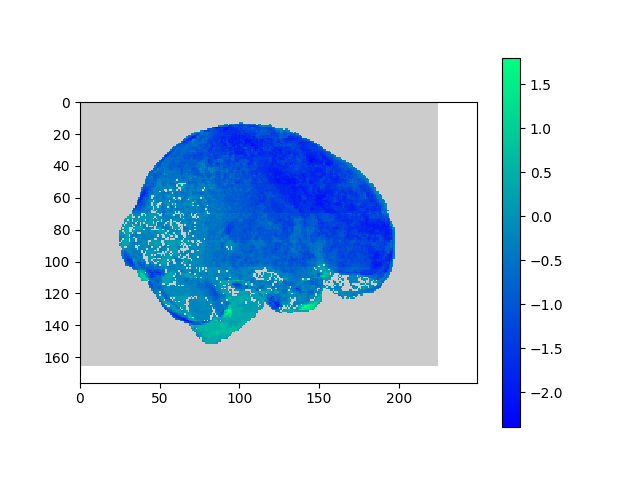

In [163]:
%matplotlib nbagg
fig, ax = plt.subplots()
ax.set_aspect(1)
brain_diff[brain_diff==0]=np.nan
palette = plt.cm.winter
palette.set_bad(alpha=0.2)
heatmap = ax.imshow(brain_diff, cmap=palette)
# heatmap = ax.pcolor(brain_diff==0, cmap=plt.cm.winter)
plt.xlim(0, 249)
plt.ylim (176,0)
plt.colorbar(heatmap)
plt.show()
plt.ion()

<IPython.core.display.Javascript object>


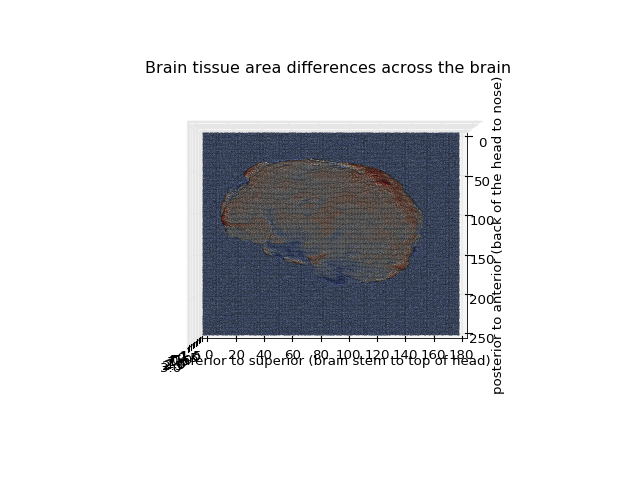

In [266]:
# https://en.wikipedia.org/wiki/Anatomical_terms_of_location

%matplotlib nbagg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure()

ax2 = fig.add_subplot(111, projection='3d')
y = np.arange(0, mask.shape[1], 1)
z = np.arange(0, mask.shape[2], 1)
Y, Z = np.meshgrid(y, z)
ax2.plot_trisurf(Y.flatten(), Z.flatten(), brain_diff.flatten(), linewidth=0.2, antialiased=True, cmap=cm.coolwarm)
ax2.set_title("Brain tissue area differences across the brain")
ax2.set_xlabel("posterior to anterior (back of the head to nose)")
ax2.set_ylabel("inferior to superior (brain stem to top of head)")
# ax2.set_zlabel("right area - left area (x 10^4 mm2)")
ax2.view_init(elev=90.0, azim=0.0)


# ax1 = fig.add_subplot(212, projection='3d')
# y = np.arange(0, mask.shape[1], 1)
# z = np.arange(0, mask.shape[2], 1)
# Y, Z = np.meshgrid(y, z)
# ax1.plot_trisurf(Y.flatten(), Z.flatten(), h_diff.flatten(), linewidth=0.2, antialiased=True, cmap=cm.coolwarm)
# ax1.set_title("Haematoma area differences across the brain")
# ax1.set_xlabel("posterior to anterior (back of the head to nose)")
# ax1.set_ylabel("inferior to superior (brain stem to top of head)")
# # ax1.set_zlabel("right area - left area (x 10^4 mm2)")
# ax1.view_init(elev=90.0, azim=0.0)

# plt.show()
# plt.ion()


<IPython.core.display.Javascript object>


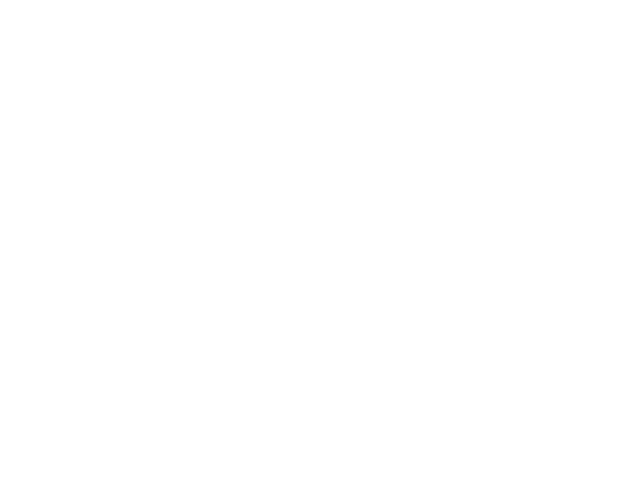

NameError: name 'data' is not defined

In [31]:
%matplotlib nbagg

import ipywidgets
from ipywidgets import interact, fixed
from scipy import interpolate

slice_no = 80
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(data[:,:,slice_no])
ax.set_xlim([0, data.shape[1]])
ax.set_ylim([data.shape[0], 0])
ax.set_title('Drawing a spline onto a slice')
plt.ion()

coords = []
spline = []
all_spl = []

def pltspline(spl):
    global data
    global ax
    global fig
    ax.imshow(data[:,:,80])
    x = spl[0].astype(int)
    y = spl[1].astype(int)
    if len(ax.lines):
        ax.lines[0].set_xdata(x)
        ax.lines[0].set_ydata(y)
    else:
        ax.plot(x,y, linewidth = 2)
    fig.canvas.draw()

def onclick(event):
    global ix, iy, iz
    ix, iy, iz = event.xdata, event.ydata, slice_no
    global coords
    coords.append((ix, iy, iz))
    np_coords = np.array(coords)
    x = np_coords[:,0]
    y = np_coords[:,1]
    global tck,u
    tck, u = interpolate.splprep([x, y], s=0)
    global spline 
    spline = interpolate.splev(np.linspace(u[0], u[-1], 200), tck)
    if len(coords)>0:
        interact(pltspline, spl=fixed(spline))
    return None

print('Click on points to draw a line which marks a boundary for the brain. When finished, click the submit spline button')
cid = fig.canvas.mpl_connect('button_press_event', onclick)

from ipywidgets import Button, HBox, VBox

words = ['Start Over', 'Delete Last Point', 'Submit Spline']
items = [Button(description=w) for w in words]

def start_over_clicked(b):

    global coords
    coords = []
    global spline
    spline = np.array([0,0])
    interact(pltspline, spl=fixed(spline))
    return None

def del_lp_clicked(b):

    global coords
    coords = coords[0:-1]
    np_coords = np.array(coords)
    if len(coords) > 3:
        x = np_coords[:,0]
        y = np_coords[:,1]
        global tck,u
        tck, u = interpolate.splprep([x, y], s=0)
        global spline 
        spline = interpolate.splev(np.linspace(u[0], u[-1], 200), tck)
        interact(pltspline, spl=fixed(spline))
    else:
        coords = []
        global spline
        spline = np.array([0,0])
        interact(pltspline, spl=fixed(spline))

    return None

def submit_spline_clicked(b):
    
    fig.canvas.mpl_disconnect(cid)
    print('Spline Submitted')
    return None
    

items[0].on_click(start_over_clicked)
items[1].on_click(del_lp_clicked)
items[2].on_click(submit_spline_clicked)

HBox([items[0], items[1], items[2]])

In [62]:
# after button click
print ax
print data
print spline
print coords

Axes(0.232839,0.1;0.559322x0.8)
[[[-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]
  ..., 
  [-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]]

 [[-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]
  ..., 
  [-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]]

 [[-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]
  ..., 
  [-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]]

 ..., 
 [[-0. -0. -0. ...,  0.  0.  0.]
  [-0. -0. -0. ...,  0.  0.  0.]
  [-0. -0. -0. ...,  0.  0. -0.]
  ..., 
  [-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]]

 [[-0. -0. -0. ..., -0.  0.  0.]
  [-0. -0. -0. ...,  0.  0.  0.]
  [-0. -0. -0. ...,  0.  0.  0.]
  ..., 
  [-0. -0. -0. ..., -0

In [63]:
# after 2 button clicks
print ax
print data
print spline
print coords

Axes(0.232839,0.1;0.559322x0.8)
[[[-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]
  ..., 
  [-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]]

 [[-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]
  ..., 
  [-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]]

 [[-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]
  ..., 
  [-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]]

 ..., 
 [[-0. -0. -0. ...,  0.  0.  0.]
  [-0. -0. -0. ...,  0.  0.  0.]
  [-0. -0. -0. ...,  0.  0. -0.]
  ..., 
  [-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]]

 [[-0. -0. -0. ..., -0.  0.  0.]
  [-0. -0. -0. ...,  0.  0.  0.]
  [-0. -0. -0. ...,  0.  0.  0.]
  ..., 
  [-0. -0. -0. ..., -0

In [112]:

x = spline[1].astype(int)
y = spline[0].astype(int)
data[x, y, slice_no] = 0
data[x-1, y, slice_no] = 0
data[x, y-1, slice_no] = 0
data[x+1, y, slice_no] = 0
data[x, y+1, slice_no] = 0
data[x-1, y-1, slice_no] = 0
data[x+1, y+1, slice_no] = 0

%matplotlib nbagg
plt.imshow(data[:,:,slice_no])
plt.show()

IndexError: list index out of range

<IPython.core.display.Javascript object>


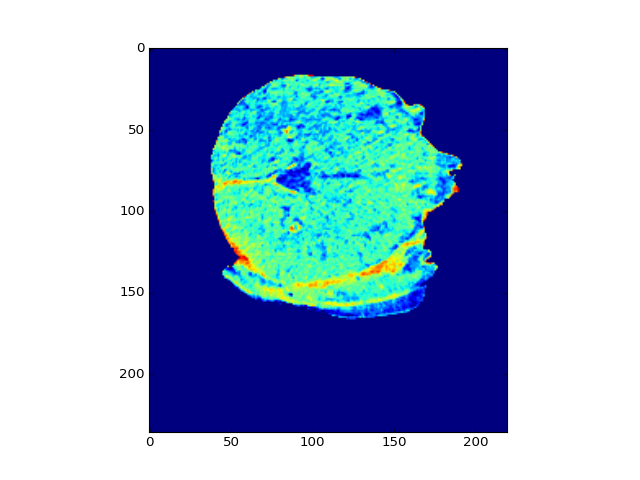

In [72]:
# data[spline[1].astype(int), spline[0].astype(int), slice_no] = 0

%matplotlib nbagg
plt.imshow(data[:,:,slice_no])
plt.show()

# data[spline[0].astype(int), spline[1].astype(int), slice_no] = 0

In [26]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4446187/figure/F1/
# reference FSL BET